# Compare NAEI & EDGAR

Calculate APO using NAEI & EDGAR to compare the models

In [1]:
import os
import glob
import numpy as np
import xarray as xr
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.convert import concentration

import apo_emiss_func, apo_plot_info, apo_funcs

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
year = 2015
months = [8, 12]

sites = ['WAO']

sigma = 3

save = False

starts = {month: datetime(year, month, 1) for month in months}
end = {month: start + relativedelta(months=1, seconds=-1) for month, start in starts.items()}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[-1]).zfill(2)}' if len(months)==2 else None

print(date_str)

201508-201512


## Show the emissions fields

In [3]:
emissions = {inv: {month: name.flux(domain = 'EUROPE',
                                    species = f'co2-{inv}-ff-1hr',
                                    start = start,
                                    end = start + relativedelta(months=1),
                                    chunks = {'time': 50})
                   for month, start in starts.items()}
             for inv in ['edgar-ukghg', 'edgar']}


Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_EUROPE_2015.nc


/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libLerc.so.4: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Slicing time to range 2015-08-01 00:00:00 - 2015-08-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_EUROPE_2015.nc
/group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_EUROPE_2016.nc


### Compare the fields

Take the average of each field and find the difference between them

In [4]:
field_averages = {month: {inv: em_inv[month].flux.values.mean()
                          for inv, em_inv in emissions.items()}
                  for month in months}

In [11]:
diff_per_cent = {month: (field_average['edgar'] - field_average['edgar-ukghg']) / field_average['edgar-ukghg'] * 100
                 for month, field_average in field_averages.items()}

In [5]:
fields_data = {inv: {month: em_month.flux[:,:,0] for month, em_month in em_inv.items()}
               for inv, em_inv in emissions.items()}
fields_data = apo_funcs.flatten_nested_dict(fields_data)
labels = [inv.split('_')[0].upper() for inv in fields_data.keys()]

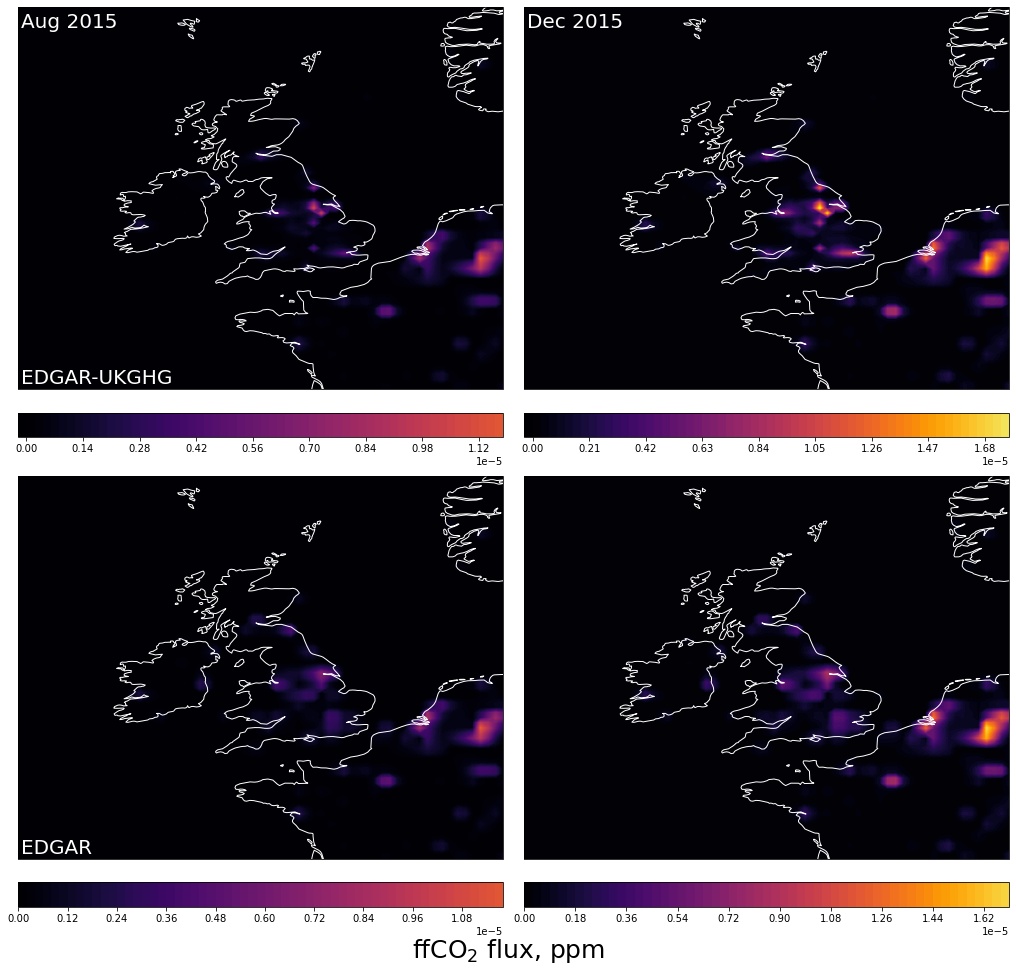

In [6]:
fig, axes = apo_funcs.show_map(data = list(fields_data.values()),
                               fig_kwargs = {'nrows':2, 'ncols':2, 'constrained_layout': True,
                                             'figsize': (14, 13)},
                               im_kwargs = {'vmin': 0, 'vmax': 1.9e-5, },
                               crop_uk = True,
                               coast_color = 'white',
                               show = False)
cbar_label = fig.text(0.5, -0.0, r'ffCO$_2$ flux, ppm', va='top', ha='center', fontsize=25)
text = [axes[0][mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[0][mm].transAxes,
                         va='top', fontsize=20, color='white')
        for mm, month in enumerate(months)]
text = [axes[ii][0].text(0.005, 0.005, f'{inv.upper()}', transform=axes[ii][0].transAxes,
                         va='bottom', fontsize=20, color='white')
        for ii, inv in enumerate(emissions.keys())]
plt.show()

### Compare the emissions fields

Get the difference in the emissions fields

In [3]:
fields_diff = {month: (emissions['edgar-ukghg'][month].flux - emissions['edgar'][month].flux)[:,:,0]
               for month in months}

fields_diff_perc = {month: abs(diff / emissions['edgar-ukghg'][month].flux[:,:,0] * 100)
                    for month, diff in fields_diff.items()}
fields_diff_perc = {month: diff.where(diff<100) for month, diff in fields_diff_perc.items()}

fields_diff_data = list(fields_data.values())[:2] + list(fields_diff.values())
fields_diff_data = [fields_diff_data[0], fields_diff_data[2], fields_diff_data[1], fields_diff_data[3]]
fields_diff_data = [ff * 1e6 for ff in fields_diff_data]

NameError: name 'emissions' is not defined

Saving figure as /user/work/vf20487/Figures/FluxFields/CO2_EDGAR_UKGHG-EDGAR_comparison_201508-201512.png


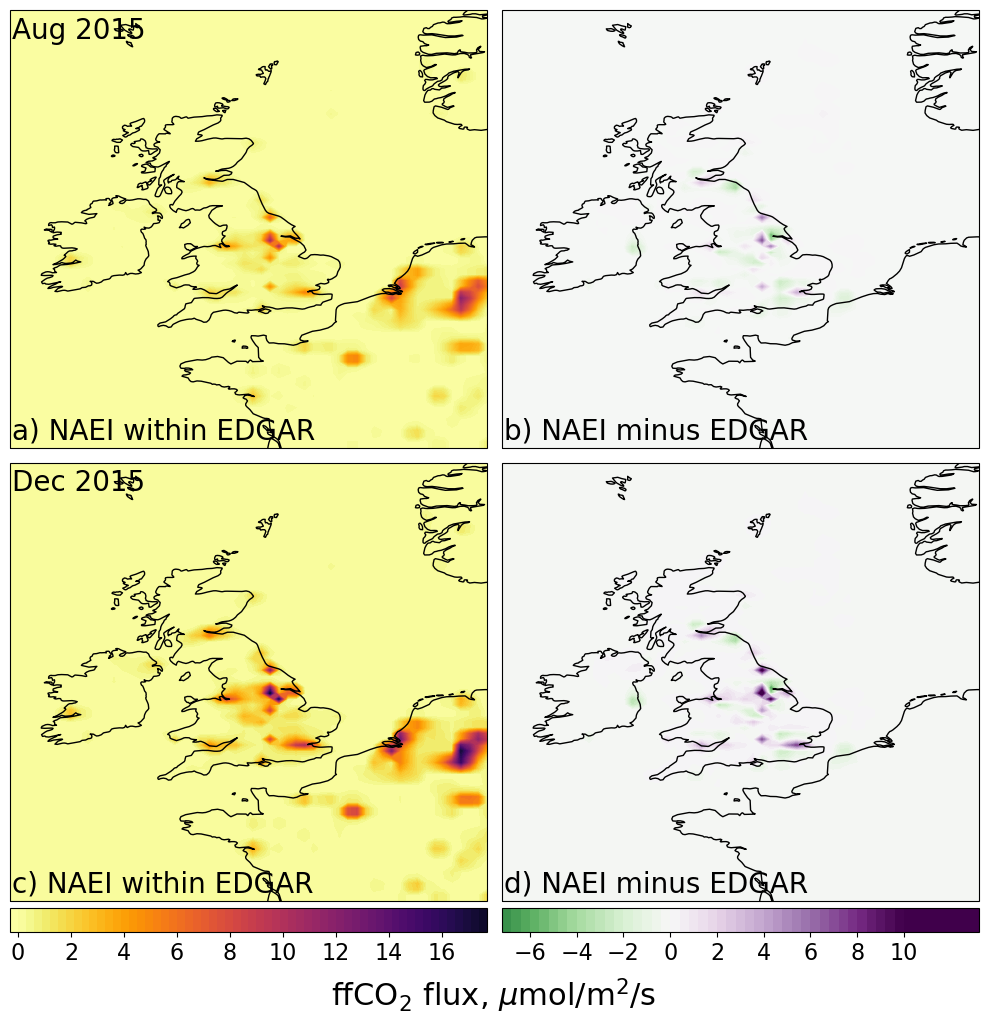

In [56]:
lat = slice(45, 63)
lon = slice(-12, 8)
# orig_map=plt.cm.get_cmap('inferno')
# reversed_map = orig_map.reversed()
fig, axes, ims = apo_funcs.show_map(data = fields_diff_data,
                                    fig_kwargs = {'figsize': (10, 12), 'nrows':2, 'ncols':2},
                                    im_kwargs = [{'cmap': 'inferno', 'vmin':-0, 'vmax':19}, {'cmap': 'PRGn', 'vmin': -10, 'vmax':10},
                                                 {'cmap': 'inferno', 'vmin': 0, 'vmax':19}, {'cmap': 'PRGn', 'vmin': -10, 'vmax':10}],
                                    colorbar = False,
                                    lat = lat,
                                    lon = lon, 
                                    coast_color = 'black',
                                    show = False,
                                    reverse_cmap = True,
                                    return_im=True
                                    )

# add colorbars
cbars = {field: [plt.colorbar(ims[ii+2], ax=axes.flat[ff], orientation='horizontal', pad=0.01, ticks=ticks) for ff in [ii+2]]
         for ii, (field, ticks) in enumerate({'fields': np.arange(0, 18, 2), 'diffs': np.arange(-6, 12, 2)}.items())}
# change the tick fontsize
[[cbar.ax.tick_params(labelsize=16) for cbar in cbar_field] for cbar_field in cbars.values()]
# add a label
cbar_label = fig.text(0.5, 0.05, r'ffCO$_2$ flux, $\mu$mol/m$^2$/s', va='top', ha='center', fontsize=22)
# add the month and year
text = [axes.flat[mm*2].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes.flat[mm*2].transAxes,
                         va='top', fontsize=20, color='black')
        for mm, month in enumerate(months)]
# add a label to show what field it is
labels = [f'{chr(97+ll)}) {label}' for ll, label in enumerate(['NAEI within EDGAR', 'NAEI minus EDGAR']*2)]
text = [axes.flat[ll].text(0.005, 0.005, f'{label}', transform=axes.flat[ll].transAxes,
                         va='bottom', fontsize=20, color='black')
        for ll, label in enumerate(labels)]

plt.tight_layout()
fig.subplots_adjust(hspace=-0.45)

file_name = os.path.join('/user', 'work', 'vf20487', 'Figures', 'FluxFields', f'CO2_EDGAR_UKGHG-EDGAR_comparison_{date_str}.png')
print(f'Saving figure as {file_name}')
fig.savefig(file_name, bbox_inches='tight', pad_inches=0.2)

## Get the timeseries

We import the pre-run forward models here

In [3]:
inv_idents = {'ukghg': '', 'edgar': '_edgar-gridfed', 'ukghg-gridfed': '_gridfed'}

sources = [f'ff{inv_ident}' for inv_ident in inv_idents.values()]
[sources.append(source) for source in ['ocean', 'bc']]
ts_data_all = apo_funcs.get_timeseries(sites = sites,
                                       sources = sources,
                                       year = year)
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end[month]))
                      for month, start in starts.items()}
               for site, ts_site in ts_data_all.items()}

for site, ts_site in ts_data_all.items():
       for month, ts_month in ts_site.items():
              ts_data_all[site][month]['apo_bc'] = ts_month.apo_bc - apo_plot_info.adjust[year][site][month]

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ff_edgar-gridfed: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_edgar-gridfed_timeseries_2015.nc']
ff_gridfed: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_gridfed_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']


/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libLerc.so.4: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


renaming co2_ff_edgar-gridfed: co2_ff_edgar_gridfed
renaming o2_ff_edgar-gridfed: o2_ff_edgar_gridfed

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ff_edgar_gridfed', 'o2_ff_edgar_gridfed', 'co2_ff_gridfed', 'o2_ff_gridfed', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc']
---------------------------



### Plot O2 and CO2

We plot the O2 and CO2 timeseries from both inventories to compare

Get the pre-run forward model for all APO components

We will use this to model APO using both ffCO2 inventories to compare

8, co2, ukghg-edgar correlation: 0.9410194138041303
8, o2, ukghg-edgar correlation: 0.9404444178401814
12, co2, ukghg-edgar correlation: 0.9048481284902866
12, o2, ukghg-edgar correlation: 0.9064781139132089


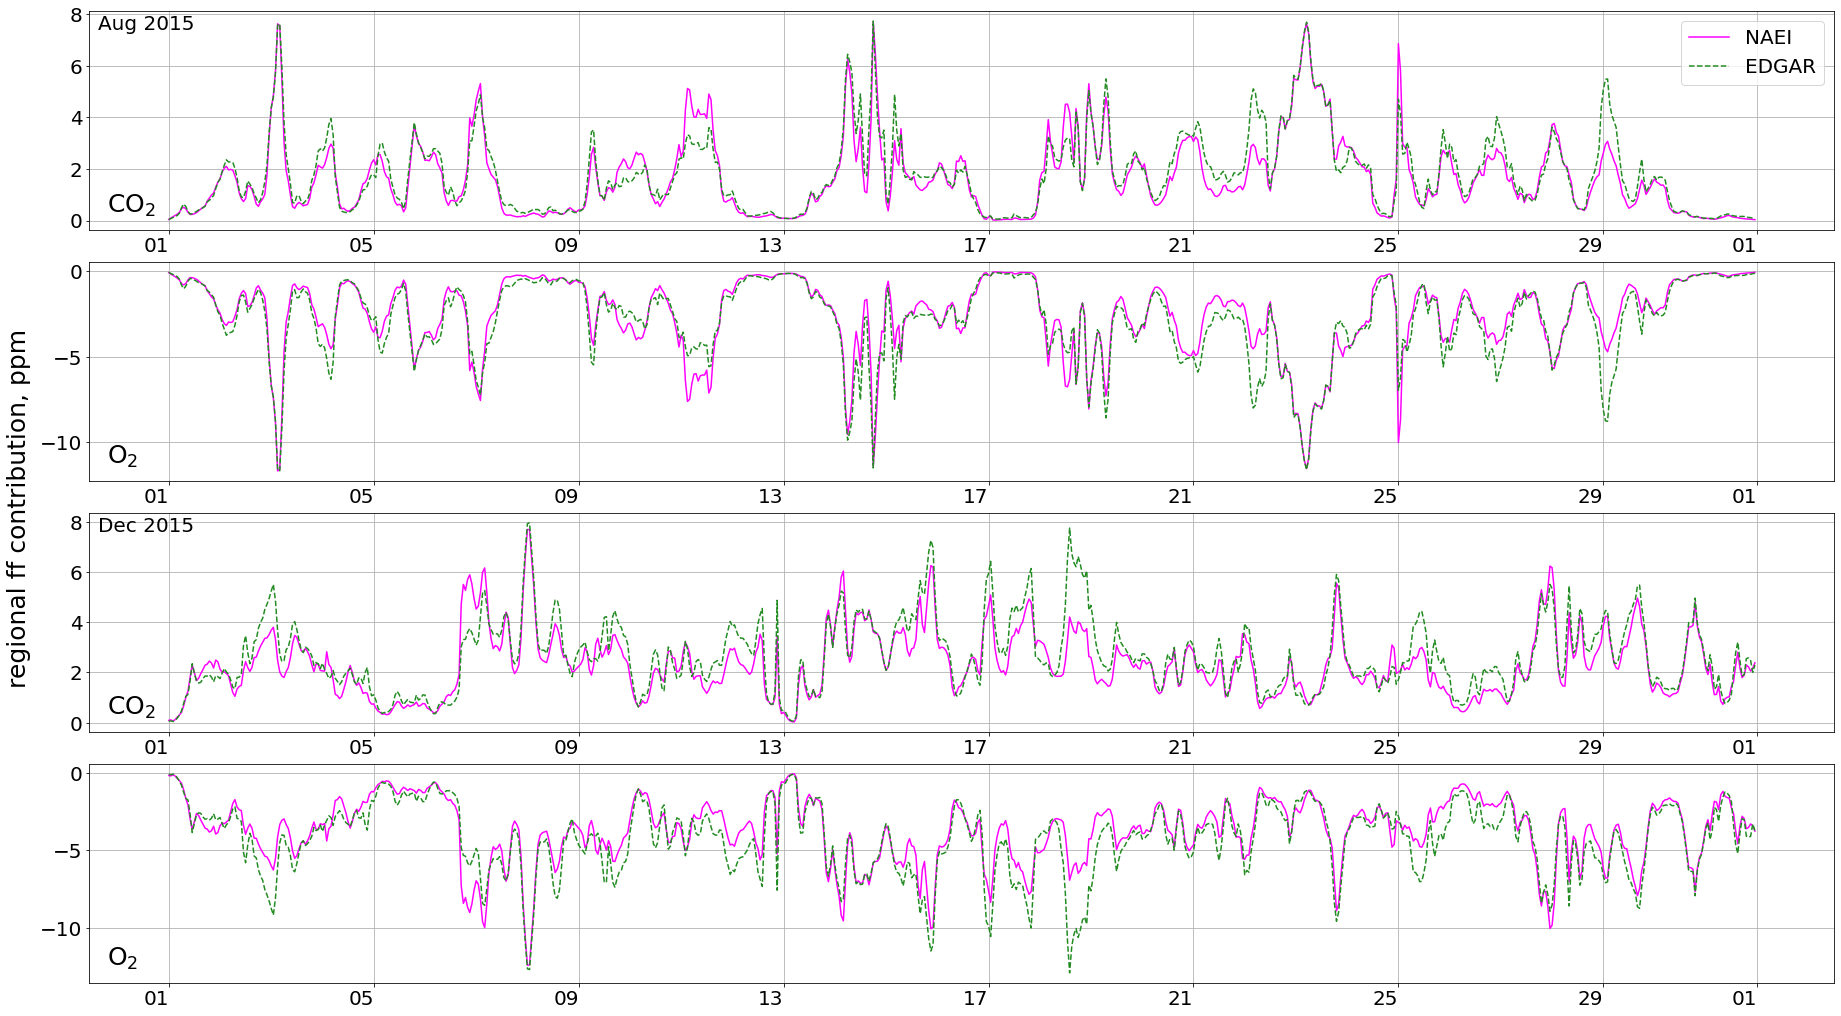

In [4]:
correlations = {month: {species: xr.corr(ts_month[f'{species}_ff'], ts_month[f'{species}_ff_edgar_gridfed'])
                        for species in ['co2', 'o2']}
                for month, ts_month in ts_data_all['WAO'].items()}

print_correlations = [[print(f'{month}, {species}, ukghg-edgar correlation: {correlation.values}')
                      for species, correlation in corr_month.items()] for month, corr_month in correlations.items()]

lines = {'ukghg': {'ls': '-', 'color': 'magenta'},
         'edgar': {'ls': '--', 'color': 'forestgreen'}}
        #  'ukghg-gridfed': {'ls': ':', 'color': 'dodgerblue'}}
labels = {'ukghg': 'NAEI', 'edgar': 'EDGAR'}

fig, axes = plt.subplots(nrows=2*len(months), ncols=1, figsize=(25, 7*len(months)), constrained_layout=True)

for mm, (month, ts_month) in enumerate(ts_data_all['WAO'].items()):
    for ss, spec in enumerate(['co2', 'o2']):
        plots = [ts_data_all['WAO'][month][f'{spec}_ff{inv_idents[inv]}'.replace('-', '_')].plot(ax=axes[ss+2*mm], label=labels[inv], ls=lines[inv]['ls'], color=lines[inv]['color'])
                 for inv, inv_ident in inv_idents.items() if inv in lines.keys()]

[axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes))[0%2::2]]]
sites_text = [r'CO$_2$', r'O$_2$']*2
[ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm*2].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*2].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

# ylabel = [axes[ss].set_ylabel(f'mol fraction contribution, ppm', fontsize=20) for ss, spec in enumerate(['CO2', 'O2'])]
grid = [ax.grid() for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, 'regional ff contribution, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
xlabel = [ax.set_xlabel('') for ax in axes]
legend = axes[0].legend(loc='best', fontsize=20)
tick_param = [ax.tick_params(axis='both', which='major', labelsize=20) for ax in axes]

date_str = '-'.join([f'{year}{str(month).zfill(2)}' for month in months])
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries',
                        f'ff_Timeseries_{date_str}.png')
if save:
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Model APO

In [4]:
apo_model = {site: {month: {sim: apo_emiss_func.apo(ocean_co2 = ts_month.co2_ocean_nemo,
                                                    ocean_n2 = ts_month.n2_ocean_nemo,
                                                    ocean_o2 = ts_month.o2_ocean_nemo,
                                                    ff_co2 = ts_month[f'co2_ff{sim_str.replace("-", "_")}'],
                                                    ff_o2 = ts_month[f'o2_ff{sim_str.replace("-", "_")}']) + ts_month.apo_adjusted_bc
                            for sim, sim_str in inv_idents.items()}
                    for month, ts_month in ts_site.items()}
             for site, ts_site in ts_data_all.items()}

### Import the APO observations

In [5]:
apo_obs = {month: get_obs(sites, 'APO', start_date, end[month], keep_missing=True)
           for month, start_date in starts.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-08-01 00:00:00 to 2015-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-12-01 00:00:00 to 2015-12-31 23:59:58.999999999


### Get the model uncertainty

We import the model uncertainty so that we can plot the ff uncertainty onto the same figure

In [6]:
path_unc = os.path.join('/user', 'work', 'vf20487', 'Sensitivities')
date_strs = {month: f'{year}{str(month).zfill(2)}' for month in months}
uncertainty_filenames = {month: glob.glob(os.path.join(path_unc, f'APO_unc*{date_str}.nc'))[0]
                         for month, date_str in date_strs.items()}
print(f'Uncertainty file: {uncertainty_filenames}')

data_unc = {month: name.open_ds(file_month) for month, file_month in uncertainty_filenames.items()}

ocean_o2_model = 'nemo'
# adjust the baseline of the APO model
# for month, data_month in data_unc.items():
#     data_unc[month][f'model_{ocean_o2_model}'] = data_month[f'model_{ocean_o2_model}'] - apo_plot_info.adjust[year][site][month]

Uncertainty file: {8: '/user/work/vf20487/Sensitivities/APO_uncertainties_201508.nc', 12: '/user/work/vf20487/Sensitivities/APO_uncertainties_201512.nc'}


In [7]:
apo_uncertainty_total = {}

for month, unc_month in data_unc.items():
        if 'ff_nemo' not in unc_month.data_vars:
                print(f'{apo_plot_info.month_names[month]}: Calculating APO uncertainty using error propagation')
                apo_uncertainty = {'co2': ((1.1 / 0.20946)**2 * (0.1*ts_data_all['WAO'][month].co2_ff)**2)**0.5,
                                   'o2': ((1.1 / 0.20946)**2 * (0.1*ts_data_all['WAO'][month].o2_ff)**2)**0.5}

                apo_uncertainty_total[month] = (apo_uncertainty['co2'][month]**2 + apo_uncertainty['o2'][month]**2)**0.5
        else:
                print(f'{apo_plot_info.month_names[month]}: Using APO uncertainty calculated using a Monte Carlo method')
                apo_uncertainty_total[month] = unc_month.ff_nemo

Aug: Using APO uncertainty calculated using a Monte Carlo method
Dec: Using APO uncertainty calculated using a Monte Carlo method


In [16]:
print_uncs = [print(f'{month}: {unc.values.std()}') for month, unc in apo_uncertainty_total.items()]

8: 0.9650819672128326
12: 0.8691211863406774


### Compare the results

- Calculate the correlations between the two models and between each model and the observations
- Plot the two APO models and the observations

In [9]:
correlations = {month: {'ukghg:edgar': xr.corr(apo_month['ukghg'], apo_month['edgar'])**2,
                        'ukghg:ukghg-gridfed': xr.corr(apo_month['ukghg'], apo_month['ukghg-gridfed'])**2,
                        'edgar:ukghg-gridfed': xr.corr(apo_month['edgar'], apo_month['ukghg-gridfed'])**2}
                for month, apo_month in apo_model[sites[0]].items()}
correlations_obs = {month: {sim: xr.corr(apo_sim, apo_obs[month][sites[0]][0].mf)**2
                            for sim, apo_sim in apo_month.items()}
                    for month, apo_month in apo_model[sites[0]].items()}

print_correlations = [[print(f'{month}, {sims} correlation: {corr_sims.values}')
                       for sims, corr_sims in corr_month.items()]
                      for month, corr_month in correlations.items()]

print('\nCorrelation with obs:')
print_correlations_obs = [[print(f'{month}, {sim} correlation: {corr_sims.values}')
                           for sim, corr_sims in corr_month.items()]
                          for month, corr_month in correlations_obs.items()]

8, ukghg:edgar correlation: 0.9570509550090733
8, ukghg:ukghg-gridfed correlation: 0.9899332763856542
8, edgar:ukghg-gridfed correlation: 0.9616613025417398
12, ukghg:edgar correlation: 0.9104920143648688
12, ukghg:ukghg-gridfed correlation: 0.9937526385229085
12, edgar:ukghg-gridfed correlation: 0.9110718124336734

Correlation with obs:
8, ukghg correlation: 0.03635655007600385
8, edgar correlation: 0.0393980818108499
8, ukghg-gridfed correlation: 0.03720005959272111
12, ukghg correlation: 0.19443889362319738
12, edgar correlation: 0.20699196937740882
12, ukghg-gridfed correlation: 0.20158061306434835


In [11]:
save = True

Saving to /user/work/vf20487/Figures/Timeseries/APO_Timeseries_edgarVukghg_201508-201512.png


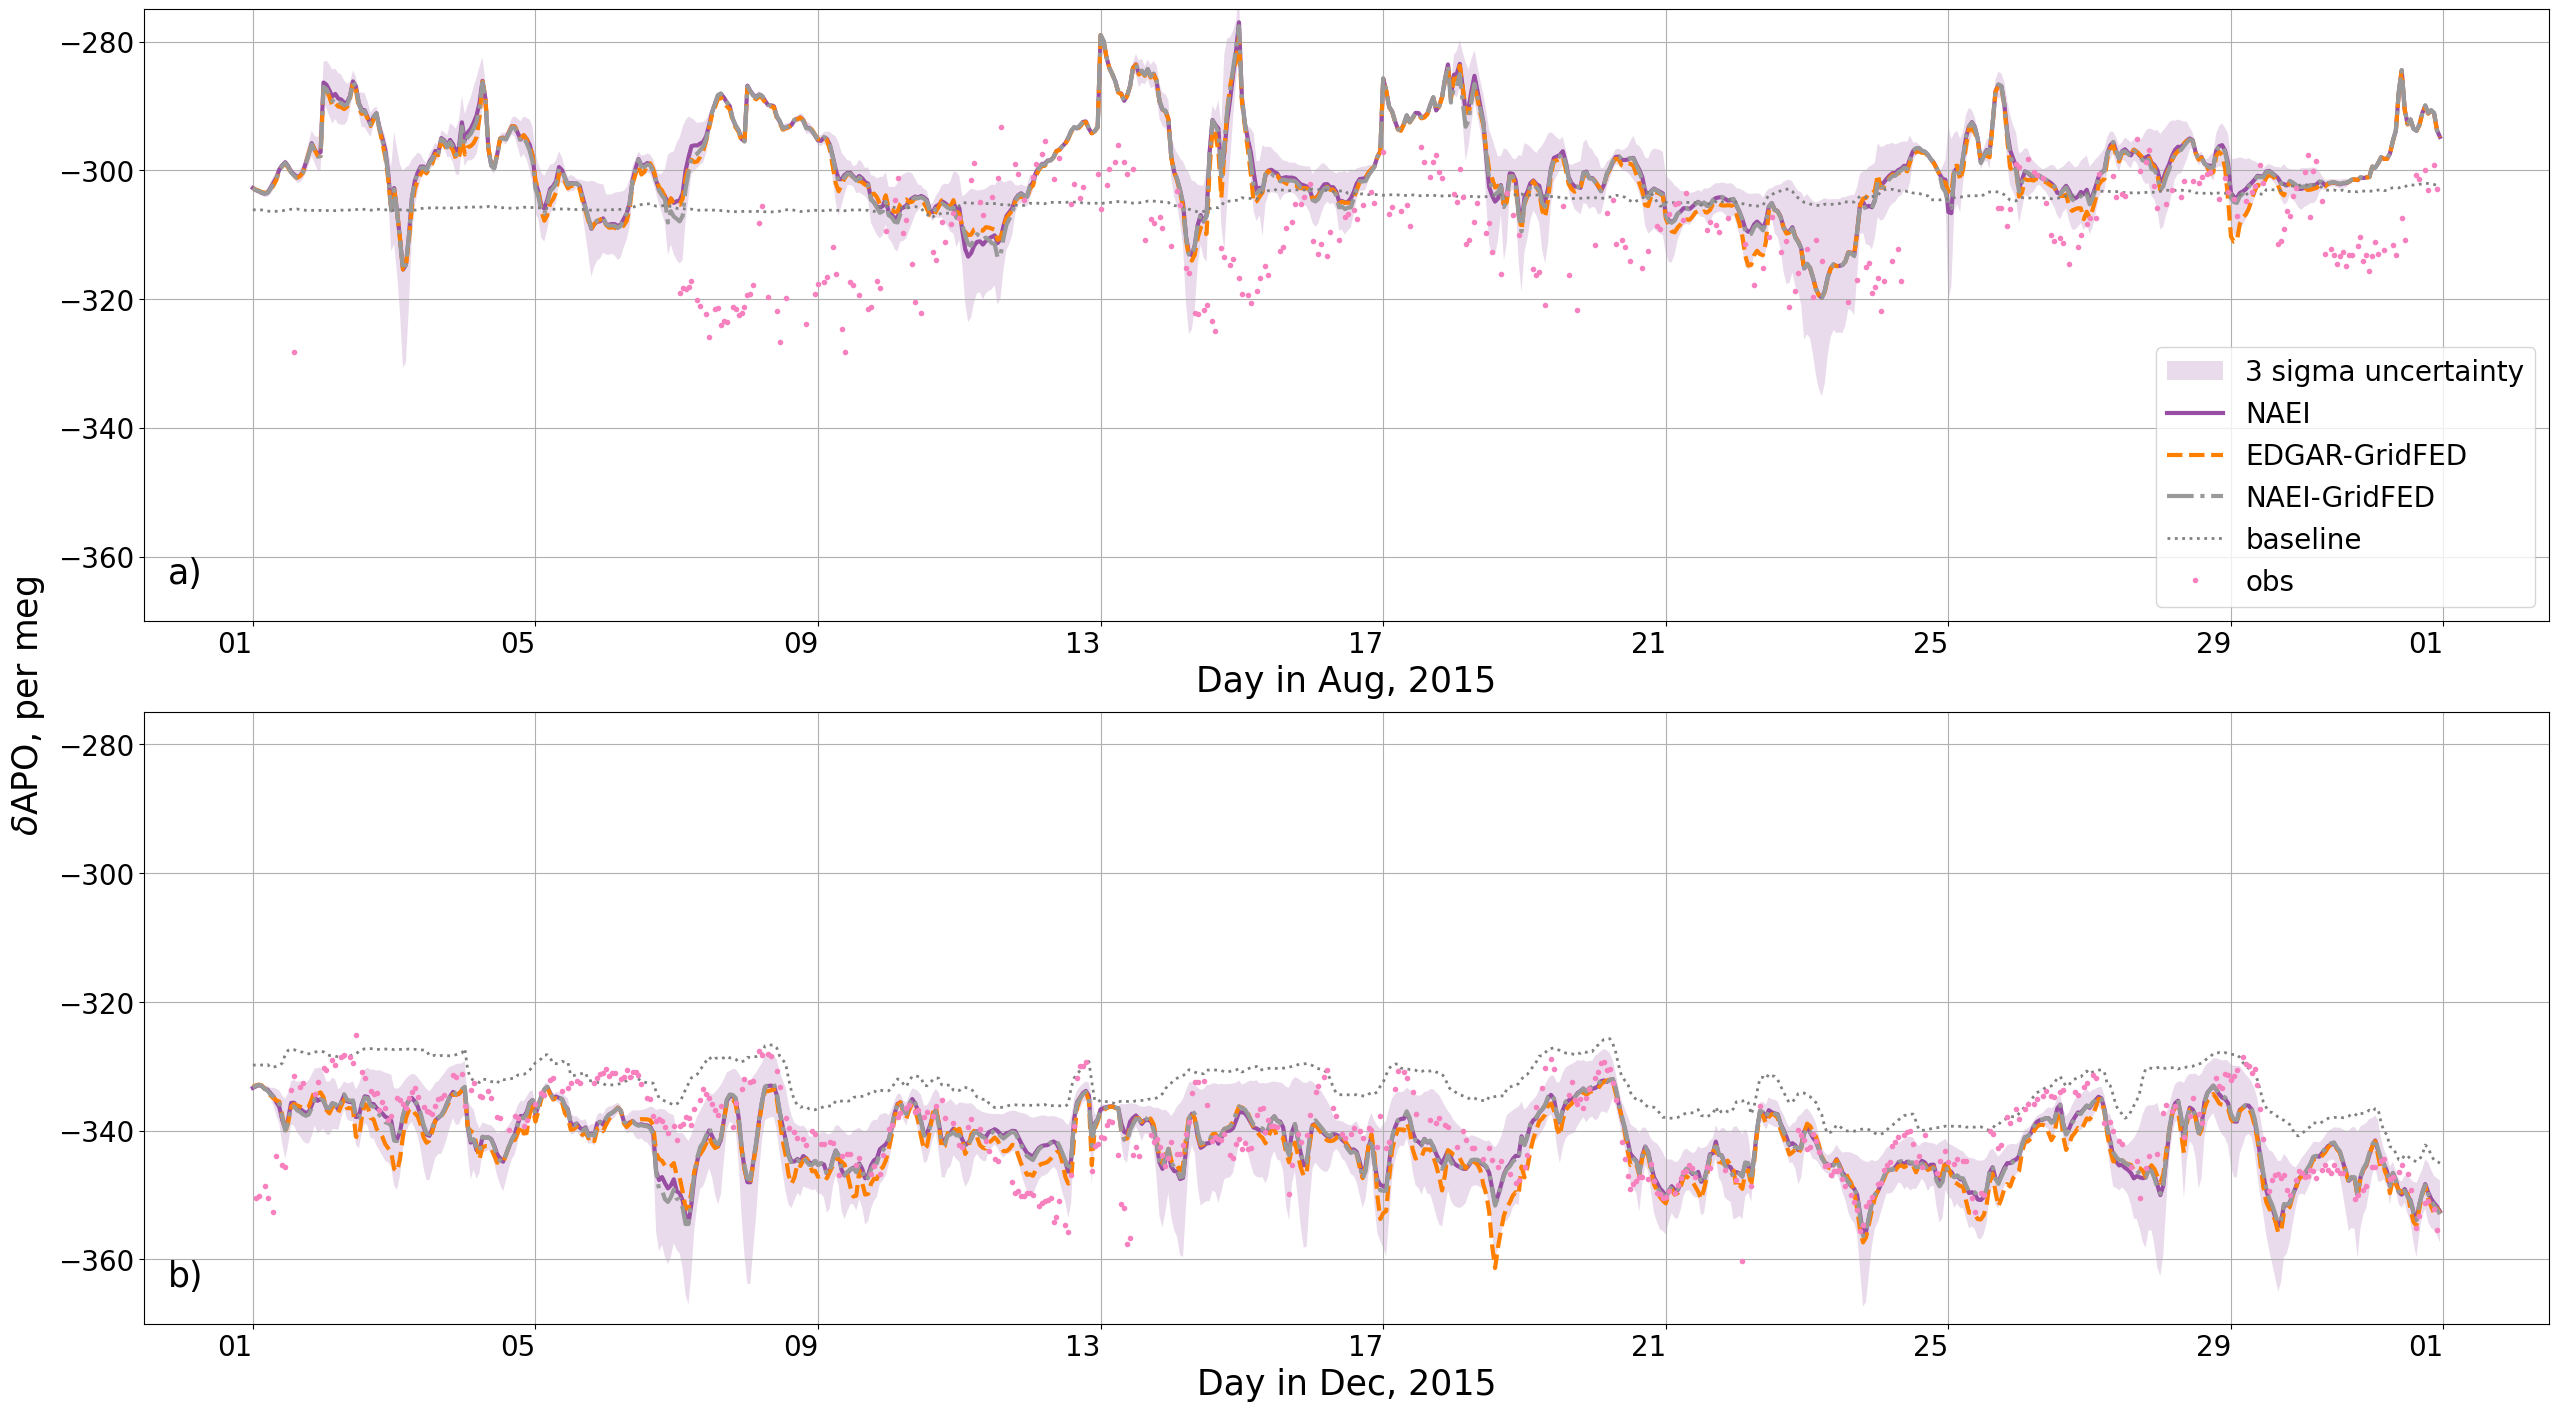

In [12]:
lines = {'ukghg': {'ls': '-', 'color': apo_plot_info.colors['nemo']},
         'edgar': {'ls': '--', 'color': '#ff7f00'}, # '#377eb8'}, # 
         'ukghg-gridfed': {'ls': '-.', 'color': '#999999'}}
        #  'ukghg-gridfed': {'ls': ':', 'color': 'dodgerblue'}}
labels = {'ukghg': 'NAEI', 'edgar': 'EDGAR-GridFED', 'ukghg-gridfed': 'NAEI-GridFED'}

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 7*len(months)), constrained_layout=True)

for mm, (month, apo_month) in enumerate(apo_model[sites[0]].items()):
    unc_plots = axes[mm].fill_between(apo_month['ukghg'].time,
                                      apo_month['ukghg']-(sigma*apo_uncertainty_total[month]),
                                      apo_month['ukghg']+(sigma*apo_uncertainty_total[month]),
                                      facecolor=apo_plot_info.colors['nemo'],
                                      alpha=0.2,
                                      label=f'{sigma} sigma uncertainty')
    plots = [ts.plot(ax=axes[mm], label=labels[inv], ls=lines[inv]['ls'], color=lines[inv]['color'], lw=3)
             for inv, ts in apo_month.items() if inv in lines.keys()]
    bc_plot = ts_data_all[sites[0]][month].apo_adjusted_bc.plot(ax=axes[mm], color='grey', ls=':', lw=2, label='baseline')

obs_plots = {month: apo_month[sites[0]][0].mf.plot(ax=axes[mm], color=apo_plot_info.colors['obs'], label='obs',
                                                   marker='o', ls='none', markersize=3)
                    if len(apo_month)>0 else None
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

xlabel = [ax.set_xlabel('') for ax in axes]
if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       # text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
       #         for mm, month in enumerate(months)]
       xlabel = [axes[mm].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25)
                  for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

# ylabel = [axes[ss].set_ylabel(f'mol fraction contribution, ppm', fontsize=20) for ss, spec in enumerate(['CO2', 'O2'])]
grid = [ax.grid() for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
ylim = [ax.set_ylim(-370, -275) for ax in axes.flat]
legend = axes[0].legend(loc='lower right', fontsize=20)
tick_param = [ax.tick_params(axis='both', which='major', labelsize=20) for ax in axes]
panel_labels = [ax.text(0.01, 0.05, f'{chr(97+aa)})', va='bottom', transform=axes[aa].transAxes, fontsize=25)
                for aa, ax in enumerate(axes.flat)]

date_str = '-'.join([f'{year}{str(month).zfill(2)}' for month in months])
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries',
                        f'APO_Timeseries_edgarVukghg_{date_str}.png')
if save:
        print(f'Saving to {filename}')
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)